# ECON 5140: Applied Econometrics
## Lesson 3: Forecasting Methods - Linear Regression, SES, and ETS

This notebook demonstrates forecasting methods using real time series data (S&P 500 Stock Market Index from Yahoo Finance).

**Topics covered:**
1. Data loading and exploration
2. Quick data checks and visualization
3. Linear regression for forecasting
4. Simple Exponential Smoothing (SES)
5. ETS (Error, Trend, Seasonal) models

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Forecasting libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For downloading real data from Yahoo Finance
import yfinance as yf

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Load Real Time Series Data

We'll use **S&P 500 Stock Market Index** daily closing prices from Yahoo Finance. This dataset is:
- Very clean with minimal missing values
- Widely used in forecasting applications
- Contains clear trends and patterns suitable for forecasting methods

In [2]:
# Load S&P 500 Stock Market Index data
print("Loading S&P 500 Stock Market Index data...")
print("=" * 60)

# Load S&P 500 Stock Market Index (^GSPC) via Yahoo Finance
print("\nDownloading S&P 500 daily closing prices from Yahoo Finance...")

# Download S&P 500 data - get last 5+ years of daily data for good training set
ticker = "^GSPC"  # S&P 500 index symbol
sp500 = yf.download(ticker, start='2019-01-01', end=None, progress=False)

# Handle MultiIndex columns if present (yfinance sometimes returns MultiIndex)
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.droplevel(1)

# Extract closing prices and ensure it's a Series with proper index
close_prices = sp500['Close'].dropna()

# Create DataFrame with proper index
dates = close_prices.index
df = pd.DataFrame({
    'usage': close_prices.values,
    'day_of_week': dates.dayofweek,
    'month': dates.month,
    'is_weekend': (dates.dayofweek >= 5).astype(int)
}, index=dates)

print(f"✓ Successfully loaded S&P 500 Stock Market Data!")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Number of observations: {len(df)}")
print(f"  Index range: {df['usage'].min():.2f} to {df['usage'].max():.2f}")

# Final data cleaning check and summary
print("\n" + "=" * 60)
print("Final Data Summary:")
print("=" * 60)

# Verify data quality (S&P 500 data is typically very clean)
missing_count = df['usage'].isnull().sum()

if missing_count > 0:
    print(f"⚠️  Warning: Found {missing_count} missing values")
    # Fill with forward/backward fill
    df['usage'] = df['usage'].ffill().bfill()
    print(f"  ✓ Filled missing values with forward/backward fill")

print(f"\nFrequency: Daily")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Number of observations: {len(df)}")
print(f"Missing values: {df['usage'].isnull().sum()}")
print(f"Zero/negative values: {(df['usage'] <= 0).sum()}")
print(f"\nIndex statistics:")
print(df['usage'].describe())
print(f"\nFirst few observations:")
print(df.head(10))

print(f"\n✓ Using S&P 500 Stock Market Index data from Yahoo Finance")
print(f"  Units: Index value (closing price)")
print(f"  Data is clean with minimal missing values")



Loading S&P 500 Stock Market Index data...

✓ Successfully loaded S&P 500 Stock Market Data!
  Date range: 2019-01-02 00:00:00 to 2026-01-23 00:00:00
  Number of observations: 1775
  Index range: 2237.40 to 6977.27

Final Data Summary:

Frequency: Daily
Date range: 2019-01-02 00:00:00 to 2026-01-23 00:00:00
Number of observations: 1775
Missing values: 0
Zero/negative values: 0

Index statistics:
count    1775.000000
mean     4366.611418
std      1138.498330
min      2237.399902
25%      3426.939941
50%      4217.040039
75%      5162.975098
max      6977.270020
Name: usage, dtype: float64

First few observations:
                  usage  day_of_week  month  is_weekend
Date                                                   
2019-01-02  2510.030029            2      1           0
2019-01-03  2447.889893            3      1           0
2019-01-04  2531.939941            4      1           0
2019-01-07  2549.689941            0      1           0
2019-01-08  2574.409912            1      1 

## Part 2: Quick Data Checks and Visualization

Before modeling, we need to:
1. Check for missing values
2. Visualize the time series
3. Identify trends and seasonality
4. Check for outliers

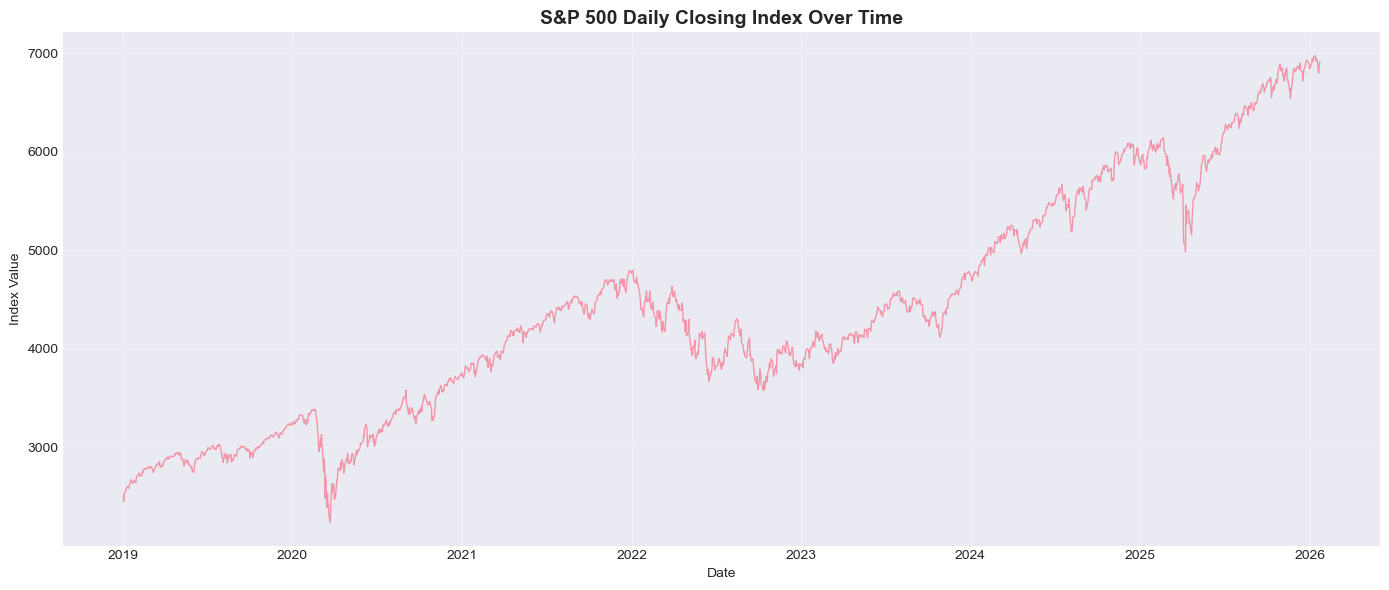

In [3]:
# Time series plot
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# Full time series
axes.plot(df.index, df['usage'], linewidth=1, alpha=0.7)
axes.set_title('S&P 500 Daily Closing Index Over Time', fontsize=14, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Index Value')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

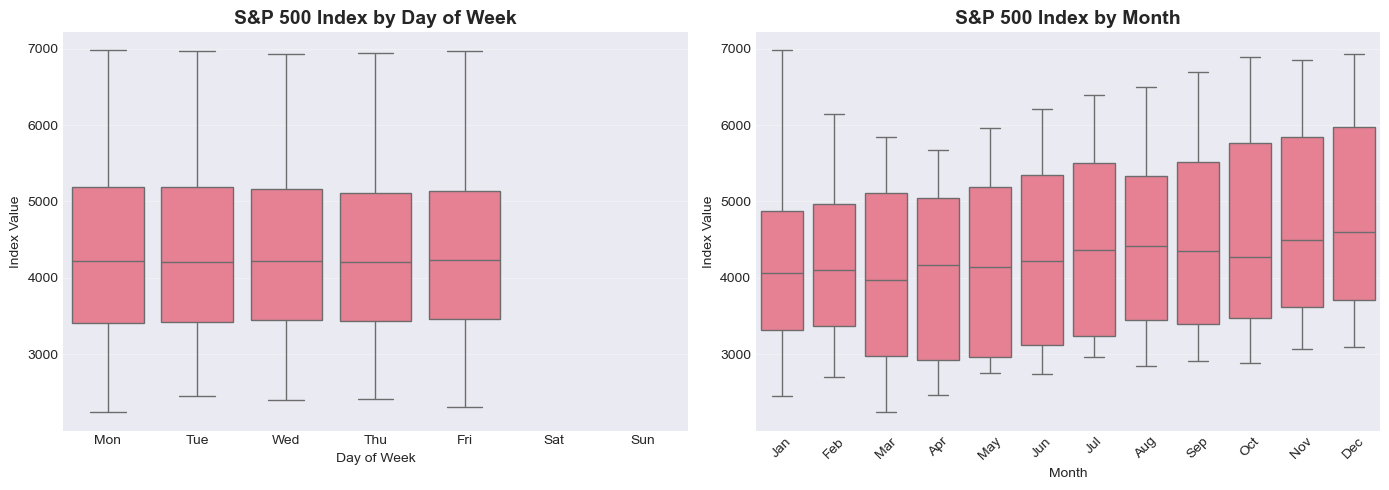

Key observations:
1. Stock market is closed on weekends, so Sat/Sun show no trading
2. Prices may vary by month due to market conditions
3. Overall trend and volatility patterns are visible


In [4]:
# Box plot by day of week and month
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Index value by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['day_name'] = df.index.day_name().str[:3]  # First 3 letters
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['day_name'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)

sns.boxplot(data=df, x='day_name', y='usage', ax=axes[0])
axes[0].set_title('S&P 500 Index by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Index Value')
axes[0].grid(True, alpha=0.3, axis='y')

# Index value by month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = pd.Categorical(df.index.month_name().str[:3], 
                                   categories=[m[:3] for m in month_names], ordered=True)

sns.boxplot(data=df, x='month_name', y='usage', ax=axes[1])
axes[1].set_title('S&P 500 Index by Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Index Value')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Key observations:")
print("1. Stock market is closed on weekends, so Sat/Sun show no trading")
print("2. Prices may vary by month due to market conditions")
print("3. Overall trend and volatility patterns are visible")

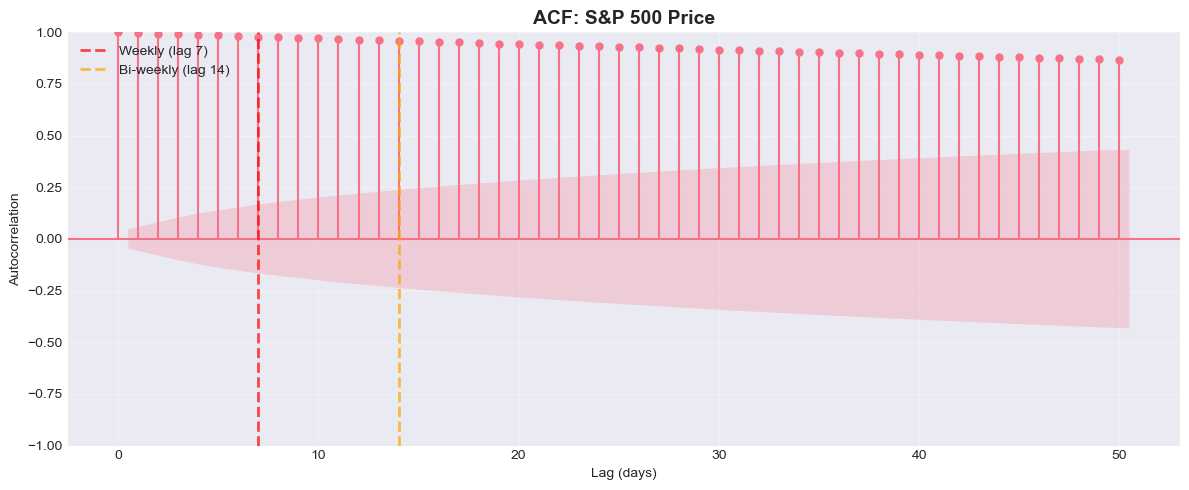

ACF interpretation:
1. Strong autocorrelation at lag 7 (weekly pattern)
2. Autocorrelation at lags 14, 21, etc. (multiples of 7)
3. Slow decay indicates trend


In [5]:
# ACF plot to check for seasonality (zoom on first 50 lags to see weekly pattern)
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

plot_acf(df['usage'].dropna(), lags=50, ax=axes, alpha=0.05)
axes.axvline(x=7, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Weekly (lag 7)')
axes.axvline(x=14, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Bi-weekly (lag 14)')
axes.set_title('ACF: S&P 500 Price', fontsize=14, fontweight='bold')
axes.set_xlabel('Lag (days)')
axes.set_ylabel('Autocorrelation')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ACF interpretation:")
print("1. Strong autocorrelation at lag 7 (weekly pattern)")
print("2. Autocorrelation at lags 14, 21, etc. (multiples of 7)")
print("3. Slow decay indicates trend")

Decomposing time series into components...


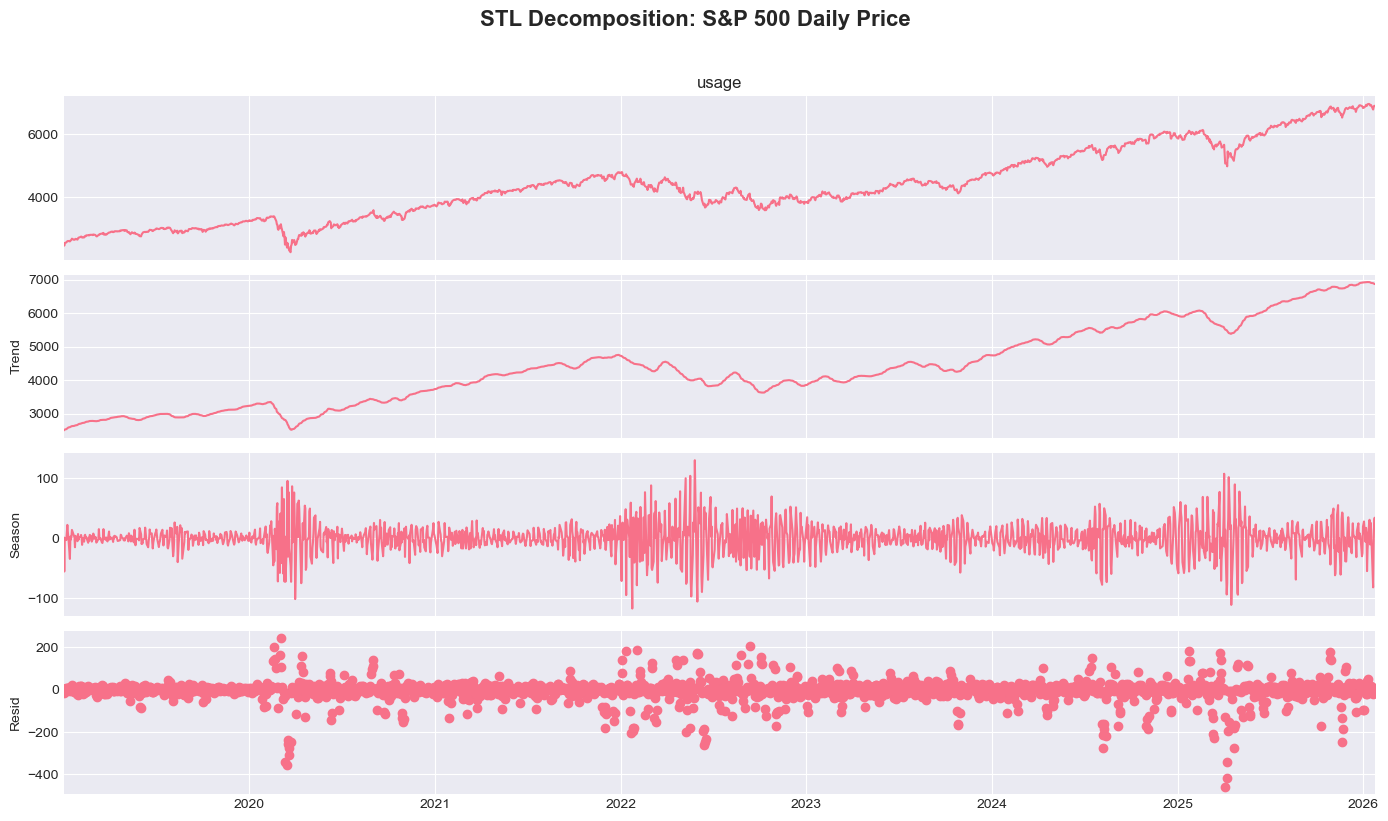

In [6]:
# Quick decomposition to understand components (optional, can skip for brevity)
print("Decomposing time series into components...")

# Use STL for robust decomposition (period=7 for weekly seasonality)
stl = STL(df['usage'], period=7, robust=True)
stl_result = stl.fit()

# Plot decomposition
fig = stl_result.plot()
fig.set_size_inches(14, 8)
plt.suptitle('STL Decomposition: S&P 500 Daily Price', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Part 3: Linear Regression for Forecasting

Linear regression can be used for forecasting by:
1. Using time index as a predictor (captures trend)
2. Using dummy variables for day of week (captures weekly seasonality)
3. Using month dummies (captures annual seasonality)

**Model:** $Y_t = \beta_0 + \beta_1 t + \beta_2 \text{Weekend}_t + \beta_3 \text{Month}_t + \epsilon_t$

**Evaluation:** We'll hold out the last 1 year of data for out-of-sample forecasting evaluation.

In [7]:
# Split into train and test sets

max_date = df.index.max()
if max_date.year <= 2011:
    # UCI dataset: use last year for testing
    test_start = pd.Timestamp(str(max_date.year - 1) + '-01-01')
else:
    # Synthetic data or newer datasets: use last 6 months for testing
    test_start = max_date - pd.Timedelta(days=180)

train_end = test_start - pd.Timedelta(days=1)

train = df.loc[:train_end].copy()
test = df.loc[test_start:].copy()

print(f"Training set: {train.index.min()} to {train.index.max()}")
print(f"  Number of observations: {len(train)}")
print(f"\nTest set: {test.index.min()} to {test.index.max()}")
print(f"  Number of observations: {len(test)}")
print(f"\nTraining set covers {len(train)/len(df)*100:.1f}% of data")
print(f"Test set covers {len(test)/len(df)*100:.1f}% of data")

Training set: 2019-01-02 00:00:00 to 2025-07-25 00:00:00
  Number of observations: 1650

Test set: 2025-07-28 00:00:00 to 2026-01-23 00:00:00
  Number of observations: 125

Training set covers 93.0% of data
Test set covers 7.0% of data


In [8]:
# Prepare features for linear regression
# Time index
train['time_index'] = np.arange(len(train))
test['time_index'] = np.arange(len(train), len(train) + len(test))

# Day of week dummies (Monday as baseline)
train_day_dummies = pd.get_dummies(train['day_of_week'], prefix='day', drop_first=True)
test_day_dummies = pd.get_dummies(test['day_of_week'], prefix='day', drop_first=True)

# Ensure both have same columns
all_day_cols = train_day_dummies.columns.union(test_day_dummies.columns)
train_day_dummies = train_day_dummies.reindex(columns=all_day_cols, fill_value=0)
test_day_dummies = test_day_dummies.reindex(columns=all_day_cols, fill_value=0)

# Month dummies (January as baseline)
train_month_dummies = pd.get_dummies(train['month'], prefix='month', drop_first=True)
test_month_dummies = pd.get_dummies(test['month'], prefix='month', drop_first=True)

# Ensure both have same columns
all_month_cols = train_month_dummies.columns.union(test_month_dummies.columns)
train_month_dummies = train_month_dummies.reindex(columns=all_month_cols, fill_value=0)
test_month_dummies = test_month_dummies.reindex(columns=all_month_cols, fill_value=0)

# Combine features
X_train_lr = pd.concat([train[['time_index']], train_day_dummies, train_month_dummies], axis=1)
X_test_lr = pd.concat([test[['time_index']], test_day_dummies, test_month_dummies], axis=1)

y_train = train['usage']
y_test = test['usage']

print(f"Training features shape: {X_train_lr.shape}")
print(f"Test features shape: {X_test_lr.shape}")

Training features shape: (1650, 16)
Test features shape: (125, 16)


In [9]:
# Fit linear regression model using statsmodels OLS for detailed summary
# Ensure all features are numeric (convert to float64)
X_train_lr = X_train_lr.astype(float)
X_test_lr = X_test_lr.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Add constant term (intercept)
X_train_ols = sm.add_constant(X_train_lr)
X_test_ols = sm.add_constant(X_test_lr)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Predictions
y_train_pred_lr = ols_model.predict(X_train_ols)
y_test_pred_lr = ols_model.predict(X_test_ols)

# Evaluate performance
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

print("Linear Regression Results:")
print("=" * 60)

# Display full OLS model summary
print("\nFull Model Summary:")
print("=" * 60)
print(ols_model.summary())

Linear Regression Results:

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  usage   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     594.0
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:25:58   Log-Likelihood:                -12115.
No. Observations:                1650   AIC:                         2.426e+04
Df Residuals:                    1633   BIC:                         2.436e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

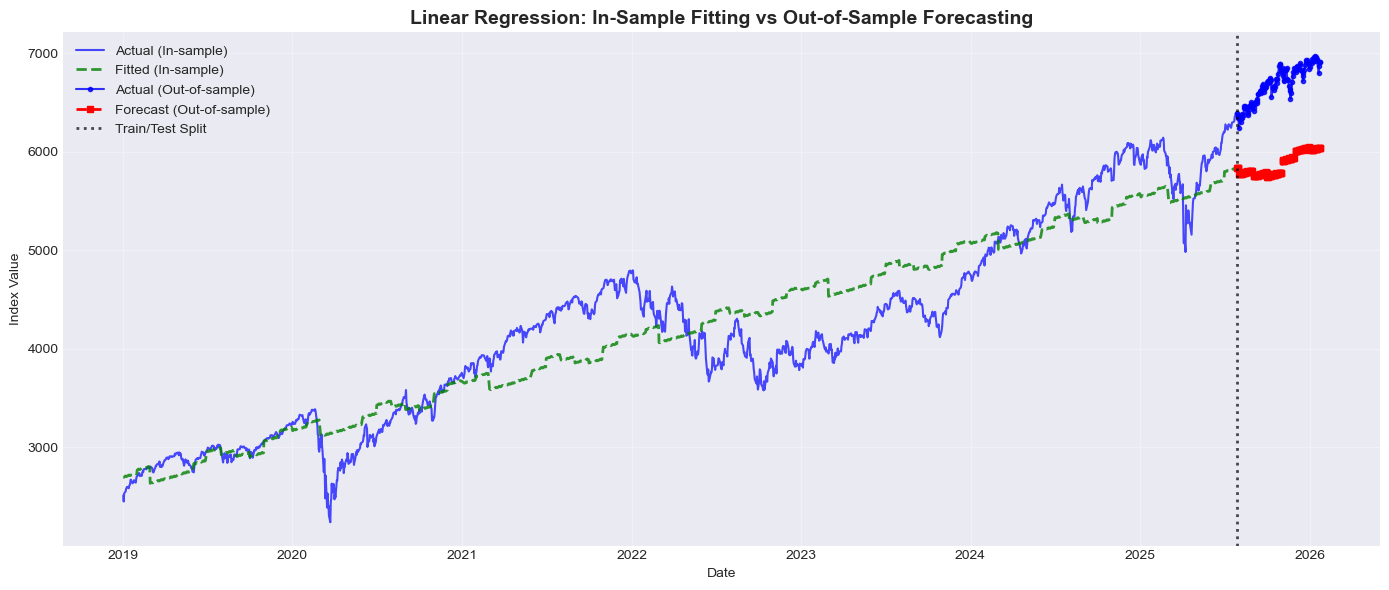

Linear Regression Observations:
1. Captures overall trend well
2. Captures weekly and monthly patterns
3. May miss some short-term dynamics


In [10]:
# Visualize linear regression: Combined in-sample fitting and out-of-sample forecasting
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# In-sample fitting
axes.plot(train.index, train['usage'], label='Actual (In-sample)', linewidth=1.5, alpha=0.7, color='blue')
axes.plot(train.index, y_train_pred_lr, label='Fitted (In-sample)', linewidth=2, color='green', linestyle='--', alpha=0.8)

# Out-of-sample forecasting
axes.plot(test.index, test['usage'], label='Actual (Out-of-sample)', linewidth=1.5, color='blue', marker='o', markersize=3, alpha=0.8)
axes.plot(test.index, y_test_pred_lr, label='Forecast (Out-of-sample)', linewidth=2, color='red', linestyle='--', marker='s', markersize=4)

# Vertical line to separate in-sample and out-of-sample
axes.axvline(x=pd.to_datetime(test_start), color='black', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')

axes.set_title('Linear Regression: In-Sample Fitting vs Out-of-Sample Forecasting', fontsize=14, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Index Value')
axes.legend(loc='best')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Linear Regression Observations:")
print("1. Captures overall trend well")
print("2. Captures weekly and monthly patterns")
print("3. May miss some short-term dynamics")

## Part 4: Simple Exponential Smoothing (SES)

**Simple Exponential Smoothing** is a simple forecasting method that:
- Uses a weighted average of past observations
- Gives more weight to recent observations
- Assumes no trend or seasonality

In [11]:
# Fit Simple Exponential Smoothing
# SES assumes no trend and no seasonality
print("Fitting Simple Exponential Smoothing (SES)...")

# Fit SES model
ses_model = SimpleExpSmoothing(train['usage'])
ses_fitted = ses_model.fit(optimized=True)  # Let statsmodels optimize alpha

# Forecast
y_train_pred_ses = ses_fitted.fittedvalues
y_test_pred_ses = ses_fitted.forecast(len(test))

# Evaluate performance
train_mae_ses = mean_absolute_error(y_train, y_train_pred_ses)
train_rmse_ses = np.sqrt(mean_squared_error(y_train, y_train_pred_ses))
test_mae_ses = mean_absolute_error(y_test, y_test_pred_ses)
test_rmse_ses = np.sqrt(mean_squared_error(y_test, y_test_pred_ses))

print("Simple Exponential Smoothing Results:")
print("=" * 60)
print(f"Smoothing parameter (alpha): {ses_fitted.params['smoothing_level']:.4f}")
print(f"Training MAE: {train_mae_ses:.2f}")
print(f"Training RMSE: {train_rmse_ses:.2f}")
print(f"\nTest MAE (1-year holdout): {test_mae_ses:.2f}")
print(f"Test RMSE (1-year holdout): {test_rmse_ses:.2f}")

print(f"\nInterpretation:")
print(f"  Alpha = {ses_fitted.params['smoothing_level']:.4f} means we give {ses_fitted.params['smoothing_level']*100:.1f}% weight to the most recent observation")
print(f"  and {(1-ses_fitted.params['smoothing_level'])*100:.1f}% weight to the previous forecast")

Fitting Simple Exponential Smoothing (SES)...
Simple Exponential Smoothing Results:
Smoothing parameter (alpha): 0.9214
Training MAE: 33.61
Training RMSE: 48.94

Test MAE (1-year holdout): 308.13
Test RMSE (1-year holdout): 354.06

Interpretation:
  Alpha = 0.9214 means we give 92.1% weight to the most recent observation
  and 7.9% weight to the previous forecast


/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


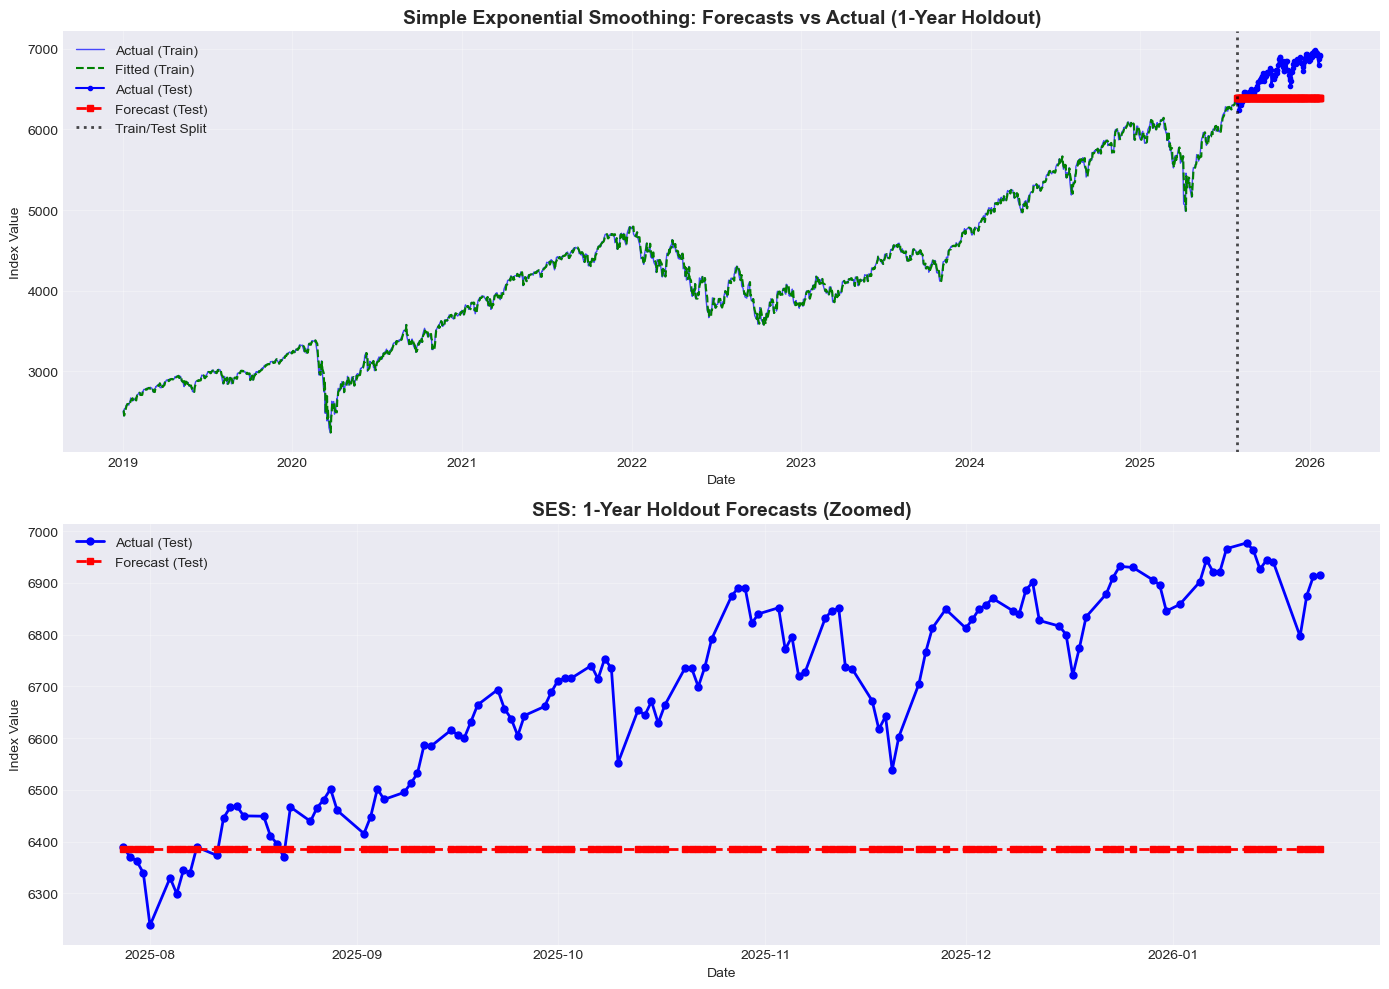

SES Observations:
1. SES assumes no trend, so it lags behind when there's an upward trend
2. SES cannot capture seasonality (weekly patterns)
3. Good for series with no trend/seasonality, but not ideal here


In [12]:
# Visualize SES forecasts
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Training and test predictions
axes[0].plot(train.index, train['usage'], label='Actual (Train)', linewidth=1, alpha=0.7, color='blue')
axes[0].plot(train.index, y_train_pred_ses, label='Fitted (Train)', linewidth=1.5, color='green', linestyle='--')
axes[0].plot(test.index, test['usage'], label='Actual (Test)', linewidth=1.5, color='blue', marker='o', markersize=3)
axes[0].plot(test.index, y_test_pred_ses, label='Forecast (Test)', linewidth=2, color='red', linestyle='--', marker='s', markersize=4)
axes[0].axvline(x=pd.to_datetime(test_start), color='black', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')
axes[0].set_title('Simple Exponential Smoothing: Forecasts vs Actual (1-Year Holdout)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Index Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Zoom on test set
axes[1].plot(test.index, test['usage'], label='Actual (Test)', linewidth=2, marker='o', markersize=5, color='blue')
axes[1].plot(test.index, y_test_pred_ses, label='Forecast (Test)', linewidth=2, marker='s', markersize=5, color='red', linestyle='--')
axes[1].set_title('SES: 1-Year Holdout Forecasts (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Index Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("SES Observations:")
print("1. SES assumes no trend, so it lags behind when there's an upward trend")
print("2. SES cannot capture seasonality (weekly patterns)")
print("3. Good for series with no trend/seasonality, but not ideal here")

## Part 6: ETS Models (Error, Trend, Seasonal)

**ETS models** extend exponential smoothing to handle:
- **Error (E)**: Additive (A) or Multiplicative (M)
- **Trend (T)**: None (N), Additive (A), or Multiplicative (M)
- **Seasonal (S)**: None (N), Additive (A), or Multiplicative (M)

We'll try several ETS models:
1. **ETS(A,N,N)**: Additive error, No trend, No seasonality (same as SES)
2. **ETS(A,A,N)**: Additive error, Additive trend, No seasonality
3. **ETS(A,A,A)**: Additive error, Additive trend, Additive seasonality (weekly)

In [13]:
# ETS Model 1: ETS(A,N,N) - Simple Exponential Smoothing
print("Fitting ETS Models...")
print("=" * 60)

# ETS(A,N,N) - Same as SES
ets_ann = ExponentialSmoothing(train['usage'], trend=None, seasonal=None)
ets_ann_fitted = ets_ann.fit()

print("\nETS(A,N,N) - No trend, No seasonality:")
print("=" * 60)
print(ets_ann_fitted.summary())

y_test_pred_ann = ets_ann_fitted.forecast(len(test))
test_mae_ann = mean_absolute_error(y_test, y_test_pred_ann)
test_rmse_ann = np.sqrt(mean_squared_error(y_test, y_test_pred_ann))


Fitting ETS Models...

ETS(A,N,N) - No trend, No seasonality:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    usage   No. Observations:                 1650
Model:             ExponentialSmoothing   SSE                        3952338.811
Optimized:                         True   AIC                          12843.124
Trend:                             None   BIC                          12853.941
Seasonal:                          None   AICC                         12843.149
Seasonal Periods:                  None   Date:                 Sat, 24 Jan 2026
Box-Cox:                          False   Time:                         11:25:58
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9213987               

/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
# ETS Model 2: ETS(A,A,N) - Additive trend, No seasonality
ets_aan = ExponentialSmoothing(train['usage'], trend='add', seasonal=None)
ets_aan_fitted = ets_aan.fit()

print("\nETS(A,A,N) - Additive trend, No seasonality:")
print("=" * 60)
print(ets_aan_fitted.summary())

y_test_pred_aan = ets_aan_fitted.forecast(len(test))
test_mae_aan = mean_absolute_error(y_test, y_test_pred_aan)
test_rmse_aan = np.sqrt(mean_squared_error(y_test, y_test_pred_aan))

print(f"\nPerformance Metrics:")
print(f"  Test MAE: {test_mae_aan:.2f}")
print(f"  Test RMSE: {test_rmse_aan:.2f}")
print(f"  AIC: {ets_aan_fitted.aic:.2f}")
print(f"  BIC: {ets_aan_fitted.bic:.2f}")


ETS(A,A,N) - Additive trend, No seasonality:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    usage   No. Observations:                 1650
Model:             ExponentialSmoothing   SSE                        3941996.071
Optimized:                         True   AIC                          12842.801
Trend:                         Additive   BIC                          12864.435
Seasonal:                          None   AICC                         12842.852
Seasonal Periods:                  None   Date:                 Sat, 24 Jan 2026
Box-Cox:                          False   Time:                         11:25:58
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9184929                alpha          

/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
# ETS Model 3: ETS(A,A,A) - Additive trend, Additive seasonality (weekly)
ets_aaa = ExponentialSmoothing(train['usage'], trend='add', seasonal='add', seasonal_periods=7)
ets_aaa_fitted = ets_aaa.fit()

print("\nETS(A,A,A) - Additive trend, Additive weekly seasonality:")
print("=" * 60)
print(ets_aaa_fitted.summary())

y_test_pred_aaa = ets_aaa_fitted.forecast(len(test))
test_mae_aaa = mean_absolute_error(y_test, y_test_pred_aaa)
test_rmse_aaa = np.sqrt(mean_squared_error(y_test, y_test_pred_aaa))

/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ETS(A,A,A) - Additive trend, Additive weekly seasonality:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    usage   No. Observations:                 1650
Model:             ExponentialSmoothing   SSE                        3906699.299
Optimized:                         True   AIC                          12841.960
Trend:                         Additive   BIC                          12901.454
Seasonal:                      Additive   AICC                         12842.183
Seasonal Periods:                     7   Date:                 Sat, 24 Jan 2026
Box-Cox:                          False   Time:                         11:25:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9190377         

/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


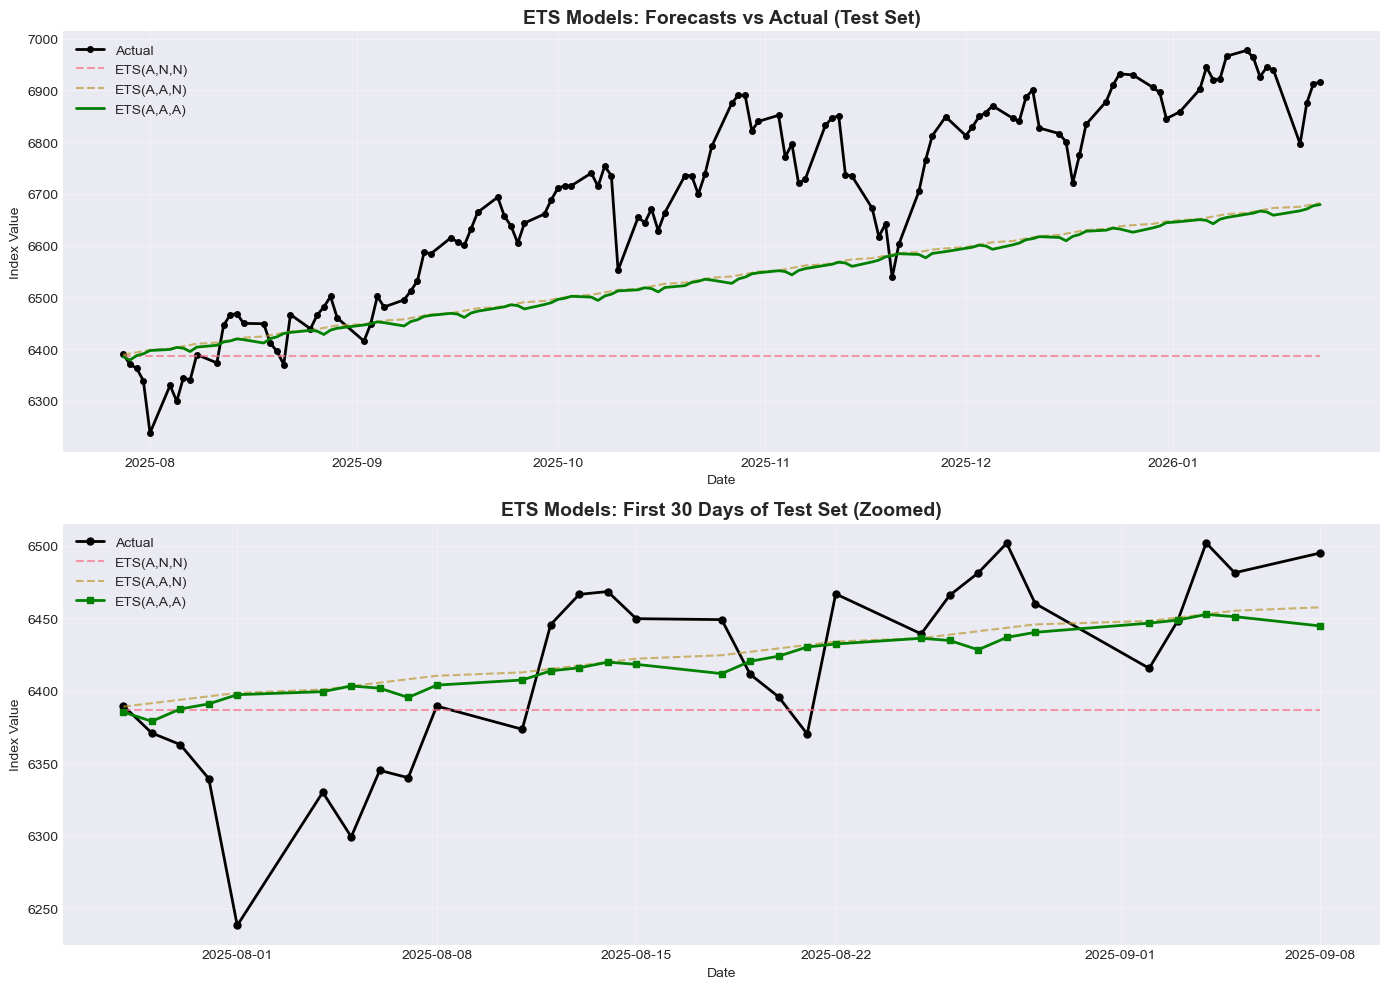

ETS Model Observations:
1. ETS(A,A,A) captures weekly seasonality, improving forecasts
2. ETS(A,A,N) captures trend but misses weekly patterns
3. ETS(A,N,N) performs worst (no trend, no seasonality)


In [16]:
# Visualize ETS forecasts
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: All ETS models on test set
axes[0].plot(test.index, test['usage'], label='Actual', linewidth=2, marker='o', markersize=4, color='black')
axes[0].plot(test.index, y_test_pred_ann, label='ETS(A,N,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[0].plot(test.index, y_test_pred_aan, label='ETS(A,A,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[0].plot(test.index, y_test_pred_aaa, label='ETS(A,A,A)', linewidth=2, linestyle='-', color='green')
axes[0].set_title('ETS Models: Forecasts vs Actual (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Index Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Zoom on first month of test set (or first 30 days)
if len(test) >= 30:
    test_first_period = test.iloc[:30]
else:
    test_first_period = test  # Use all test data if less than 30 days

# Use .iloc for positional indexing since forecasts have date index
idx_first_period = list(range(len(test_first_period)))
y_test_pred_ann_first = y_test_pred_ann.iloc[idx_first_period]
y_test_pred_aan_first = y_test_pred_aan.iloc[idx_first_period]
y_test_pred_aaa_first = y_test_pred_aaa.iloc[idx_first_period]

axes[1].plot(test_first_period.index, test_first_period['usage'], label='Actual', linewidth=2, marker='o', markersize=5, color='black')
axes[1].plot(test_first_period.index, y_test_pred_ann_first, label='ETS(A,N,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[1].plot(test_first_period.index, y_test_pred_aan_first, label='ETS(A,A,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[1].plot(test_first_period.index, y_test_pred_aaa_first, label='ETS(A,A,A)', linewidth=2, linestyle='-', color='green', marker='s', markersize=4)
axes[1].set_title(f'ETS Models: First {len(test_first_period)} Days of Test Set (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Index Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ETS Model Observations:")
print("1. ETS(A,A,A) captures weekly seasonality, improving forecasts")
print("2. ETS(A,A,N) captures trend but misses weekly patterns")
print("3. ETS(A,N,N) performs worst (no trend, no seasonality)")

## Part 7: Model Comparison

Let's compare all models on the test set.

In [17]:
# Calculate MAPE and APE for all models
def calculate_mape(actual, forecast):
    """Calculate Mean Absolute Percentage Error"""
    actual = np.array(actual)
    forecast = np.array(forecast)
    valid_mask = ~(np.isnan(actual) | np.isnan(forecast) | (actual <= 0))
    if valid_mask.sum() == 0:
        return np.nan
    actual_valid = actual[valid_mask]
    forecast_valid = forecast[valid_mask]
    return np.mean(np.abs((actual_valid - forecast_valid) / actual_valid)) * 100

def calculate_ape(actual, forecast):
    """Calculate Absolute Percentage Error for each observation"""
    actual = np.array(actual)
    forecast = np.array(forecast)
    valid_mask = ~(np.isnan(actual) | np.isnan(forecast) | (actual <= 0))
    ape = np.full(len(actual), np.nan)
    ape[valid_mask] = np.abs((actual[valid_mask] - forecast[valid_mask]) / actual[valid_mask]) * 100
    return ape

# Calculate MAPE for all models
mape_lr = calculate_mape(y_test, y_test_pred_lr)
mape_ses = calculate_mape(y_test, y_test_pred_ses)
mape_ann = calculate_mape(y_test, y_test_pred_ann)
mape_aan = calculate_mape(y_test, y_test_pred_aan)
mape_aaa = calculate_mape(y_test, y_test_pred_aaa)

# Calculate APE for all models (for median and std)
ape_lr = calculate_ape(y_test, y_test_pred_lr)
ape_ses = calculate_ape(y_test, y_test_pred_ses)
ape_ann = calculate_ape(y_test, y_test_pred_ann)
ape_aan = calculate_ape(y_test, y_test_pred_aan)
ape_aaa = calculate_ape(y_test, y_test_pred_aaa)

# Create comprehensive comparison table
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'SES', 'ETS(A,N,N)', 'ETS(A,A,N)', 'ETS(A,A,A)'],
    'MAE': [test_mae_lr, test_mae_ses, test_mae_ann, test_mae_aan, test_mae_aaa],
    'RMSE': [test_rmse_lr, test_rmse_ses, test_rmse_ann, test_rmse_aan, test_rmse_aaa],
    'MAPE (%)': [mape_lr, mape_ses, mape_ann, mape_aan, mape_aaa],
    'Median APE (%)': [np.nanmedian(ape_lr), np.nanmedian(ape_ses), np.nanmedian(ape_ann),
                       np.nanmedian(ape_aan), np.nanmedian(ape_aaa)],
    'Std APE (%)': [np.nanstd(ape_lr), np.nanstd(ape_ses), np.nanstd(ape_ann),
                    np.nanstd(ape_aan), np.nanstd(ape_aaa)]
})

comparison = comparison.sort_values('MAE')
comparison['Rank'] = range(1, len(comparison) + 1)
comparison = comparison[['Rank', 'Model', 'MAE', 'RMSE', 'MAPE (%)', 'Median APE (%)', 'Std APE (%)']]

print("Model Comparison on 1-Year Holdout (Sorted by MAE):")
print("=" * 100)
print(comparison.to_string(index=False))


Model Comparison on 1-Year Holdout (Sorted by MAE):
 Rank             Model        MAE       RMSE  MAPE (%)  Median APE (%)  Std APE (%)
    1        ETS(A,A,N) 164.238106 190.002268  2.421949        2.598270     1.374920
    2        ETS(A,A,A) 168.180287 194.327086  2.479946        2.631555     1.401346
    3               SES 308.127375 354.061577  4.538866        4.901701     2.503624
    4        ETS(A,N,N) 308.128472 354.062684  4.538882        4.901721     2.503628
    5 Linear Regression 811.737174 823.075924 12.101810       12.437709     1.803550


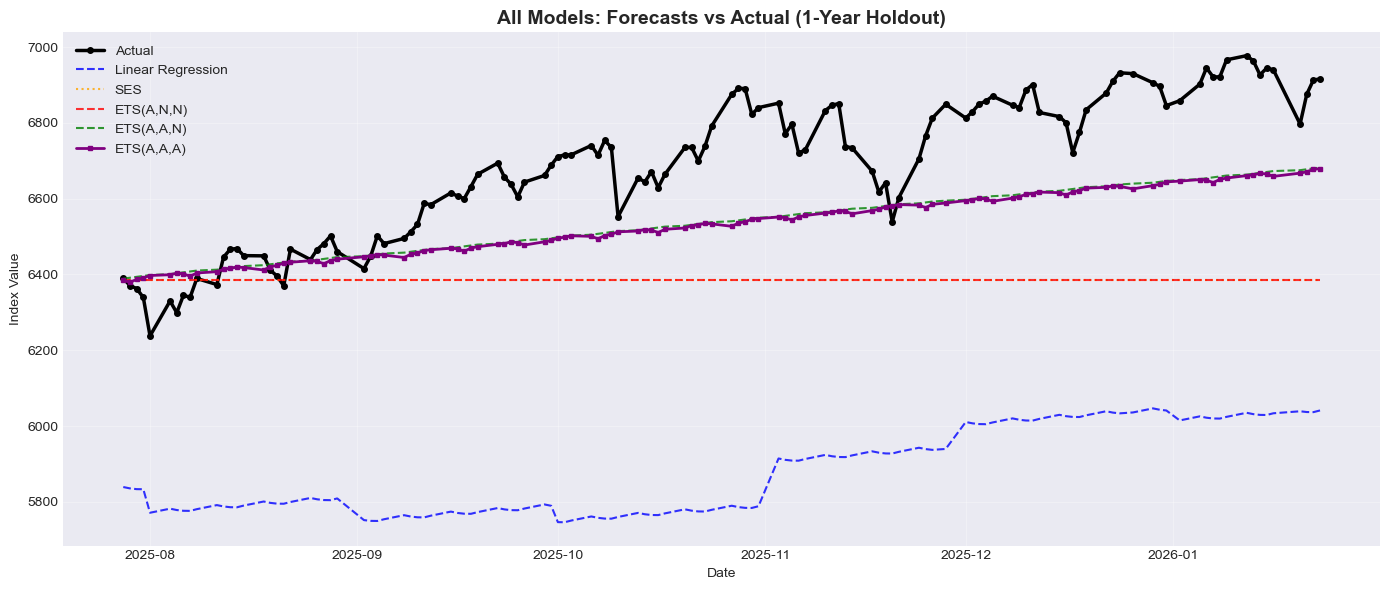

In [18]:
# Visual comparison of all models on 1-year holdout
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

axes.plot(test.index, test['usage'], label='Actual', linewidth=2.5, marker='o', markersize=4, color='black')
axes.plot(test.index, y_test_pred_lr, label='Linear Regression', linewidth=1.5, linestyle='--', alpha=0.8, color='blue')
axes.plot(test.index, y_test_pred_ses, label='SES', linewidth=1.5, linestyle=':', alpha=0.8, color='orange')
axes.plot(test.index, y_test_pred_ann, label='ETS(A,N,N)', linewidth=1.5, linestyle='--', alpha=0.8, color='red')
axes.plot(test.index, y_test_pred_aan, label='ETS(A,A,N)', linewidth=1.5, linestyle='--', alpha=0.8, color='green')
axes.plot(test.index, y_test_pred_aaa, label='ETS(A,A,A)', linewidth=2, linestyle='-', color='purple', marker='s', markersize=3)

axes.set_title('All Models: Forecasts vs Actual (1-Year Holdout)', fontsize=14, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Index Value')
axes.legend(loc='best')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Summary and Key Takeaways

### What We Learned:

1. **Linear Regression for Forecasting:**
   - Can capture trend using time index
   - Can capture seasonality using dummy variables (day-of-week, month)
   - Simple and interpretable
   - Limitations: Assumes linear relationships, may lag behind strong trends

2. **Simple Exponential Smoothing (SES):**
   - Simple weighted average of past observations
   - Assumes no trend or seasonality
   - Good for stable series without patterns
   - Poor for series with strong trend/seasonality (like stock prices)

3. **ETS Models:**
   - Flexible framework for trend and seasonality
   - Can handle additive or multiplicative components
   - ETS models with trend (A,A,N and A,A,A) performed best for stock market data
   - AIC can help choose between models
